# Импорт данных

Источник данных один - объединение и переформатирование (приведение к единому формату) не требуется

In [29]:
# Импорт библиотек
import pandas as pd
from sklearn.pipeline import Pipeline


from sklearn.linear_model import LinearRegression #линейная регрессия
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor



from sklearn.preprocessing import StandardScaler # Стандартизация
from sklearn.model_selection import train_test_split #разделение на обучающую и тестовую выборки

from sklearn.metrics import PredictionErrorDisplay #Визуализация отклонений

from sklearn.utils import shuffle # Функция перемешивания данных

from sklearn.model_selection import cross_val_score # Кросс валидация
from sklearn.model_selection import KFold #Методы кросс валидации разделением на K фолдов

from sklearn.model_selection import GridSearchCV #Поиск параметров по сетке

from joblib import dump, load # Сохранение и загрузка моделей

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.neural_network import MLPRegressor

from keras import Sequential

from keras.layers import Dense, Activation
from keras import layers


import warnings
warnings.filterwarnings("ignore")

In [30]:
# Импорт данных из файла
raw_data = pd.read_excel('./data/raw/ebw_data.xlsx')

# Смотрим данные

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   IW      72 non-null     int64  
 1   IF      72 non-null     int64  
 2   VW      72 non-null     float64
 3   FP      72 non-null     int64  
 4   Depth   72 non-null     float64
 5   Width   72 non-null     float64
dtypes: float64(3), int64(3)
memory usage: 3.5 KB
None
              IW          IF         VW          FP      Depth      Width
count  72.000000   72.000000  72.000000   72.000000  72.000000  72.000000
mean   45.666667  141.333333   8.638889   78.333333   1.195556   1.970417
std     1.678363    5.145763   2.061078   21.493530   0.225081   0.279040
min    43.000000  131.000000   4.500000   50.000000   0.800000   1.680000
25%    44.000000  139.000000   8.000000   60.000000   1.080000   1.760000
50%    45.500000  141.000000   9.000000   80.000000   1.200000   1.840000
75%    47.000000  146.000000 

<Axes: >

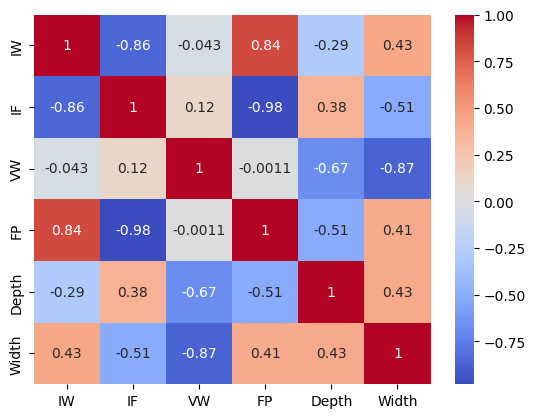

In [31]:
# Смотрим пропуски
print(raw_data.info())
# Смотрим статистику по данным
print(raw_data.describe())
# Cмотрим корреляцию
sns.heatmap(raw_data.corr(), cmap = 'coolwarm', annot = True)

Между FP и IF наблюдается сильная отрицательная корреляция. Эти признаки практически инвертированы.

IF и FP имеют сильную положительную корреляцию.

Фичи достаточно сильно скоррелированы но из-за малого пространства признаков и малого кол-ва наблюдений избавлять от признаков нет смысла т.к. при этом потеряется информация которой и так немного

## Определение плотности и характера распределения

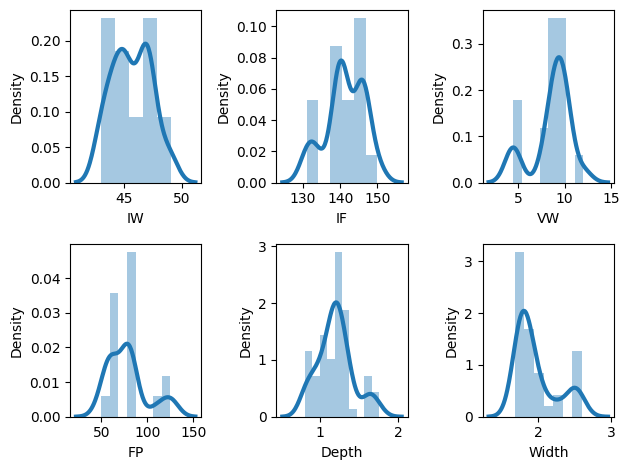

In [32]:
# Проходим по каждому столбцу
for column in raw_data:

    subplot = plt.subplot(2,3,raw_data.columns.get_loc(column)+1)

    subplot = sns.distplot(raw_data[column], hist = True, kde = True,
                 kde_kws = {'linewidth': 3},
                 label = column)

# Строим график
plt.tight_layout()
plt.show()

In [33]:
# Вычисление квартилей и IQR
Q1 = raw_data.quantile(0.25)
Q3 = raw_data.quantile(0.75)
IQR = Q3 - Q1

# Подсчет количества выбросов
count_out = raw_data[(raw_data < (Q1 - 1.5 * IQR)) | (raw_data > (Q3 + 1.5 * IQR))].count()
# Создание DataFrame с количеством выбросов
df_count_out = pd.DataFrame(count_out, columns=['count_out'])
# Вычисление общего количества значений в каждом столбце
total_values = raw_data.count()
# Вычисление доли выбросов
df_count_out['fraction_out'] = df_count_out['count_out'] / total_values
# Отображение DataFrame с количеством выбросов и их долей
df_count_out

,count_out,fraction_out
IW,0,0.000000
IF,0,0.000000
VW,12,0.166667
FP,8,0.111111
Depth,6,0.083333
Width,7,0.097222


Нет оснований полагать, что выбросы относительно средних значений являются чем-то специфичным, т.к. их достаточно много 11-16% в зависимости от анализируемой фичи. Предположим, что это не будет критичным для наших данных и не будем ничего с этим делать. Если модель покажет низкую точность - тогда обучим её еще раз преварительно поработав с выбросами.

# Предобработка


Категориальных признаков нет - кодирование не требуется

Пропусков нет - заполнение не требуется

Все фичи(признаки) значимые - удалять ничего не требуется.

Объединять фичи и создавать производные фичи не требуется.

Характер распределения не всегда близок к нормальному - применим стандартизацию.

In [34]:

y = raw_data[['Depth', 'Width']]
X = raw_data.drop(['Depth', 'Width'], axis = 1)

scaler= StandardScaler()

X_Standardized=pd.DataFrame(scaler.fit_transform(X), columns = X.columns)

print(X_Standardized)
print(y)

     IW        IF        VW        FP
0   0.8 -0.456630 -2.022210  0.078087
1   0.8 -0.456630 -2.022210  0.078087
2   0.8 -0.456630 -2.022210  0.078087
3   0.8 -0.456630 -2.022210  0.078087
4  -0.4 -0.260931 -2.022210  0.078087
..  ...       ...       ...       ...
67 -1.0  0.913259  0.176434 -0.858956
68 -0.4  0.913259  0.176434 -0.858956
69 -0.4  0.913259  0.176434 -0.858956
70 -0.4  0.913259  0.176434 -0.858956
71 -0.4  0.913259  0.176434 -0.858956

[72 rows x 4 columns]
    Depth  Width
0    1.60   2.54
1    1.62   2.50
2    1.68   2.60
3    1.58   2.52
4    1.76   2.48
..    ...    ...
67   1.20   1.72
68   1.36   1.76
69   1.28   1.76
70   1.28   1.76
71   1.32   1.76

[72 rows x 2 columns]


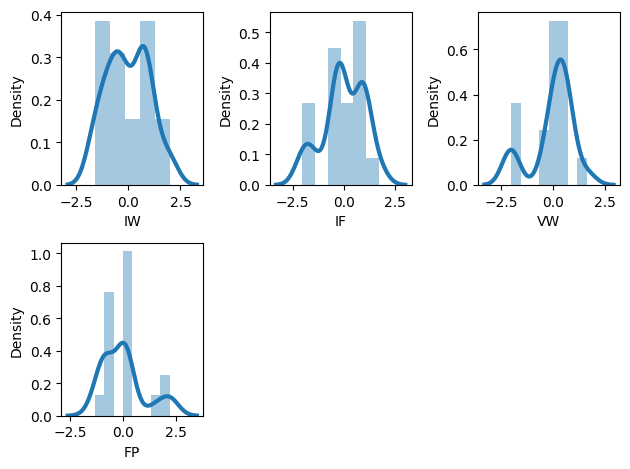

In [35]:
# Проходим по каждому столбцу
for column in X_Standardized:

    subplot = plt.subplot(2,3,X_Standardized.columns.get_loc(column)+1)

    subplot = sns.distplot(X_Standardized[column], hist = True, kde = True,
                 kde_kws = {'linewidth': 3},
                 label = column)

# Строим график
plt.tight_layout()
plt.show()

Стандартизация выполнена успешно, данные отцентровались.

Разделим выборку на обучающую и тестовую

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X_Standardized, y,
                                                    test_size = 0.2,
                                                    shuffle = True,
                                                    random_state = 42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

# Сохраняем данные
X_train.to_excel('./data/processed/X_train.xlsx', index=False)
X_test.to_excel('./data/processed/X_test.xlsx', index=False)
y_train.to_excel('./data/processed/y_train.xlsx', index=False)
y_test.to_excel('./data/processed/y_test.xlsx', index=False)

(57, 4)
(15, 4)
(57, 2)
(15, 2)


# Обучение модели

Изначально в качестве метрики использовалась R2, но как оказалось - эта метрика зависит от порядка следования измерений и при кросс валидации выдает рандомные значения в зафисимости от качества перемешивания датасета. Поэтому от этой метрики было решено отказаться

## Линейная регрессия

### Для тестовой и обучающей выборки

In [37]:
lr = LinearRegression()
lr.fit(X_train, y_train) #обучение на тестовой выборке

# получаем предсказание модели
y_predict = lr.predict(X_test)

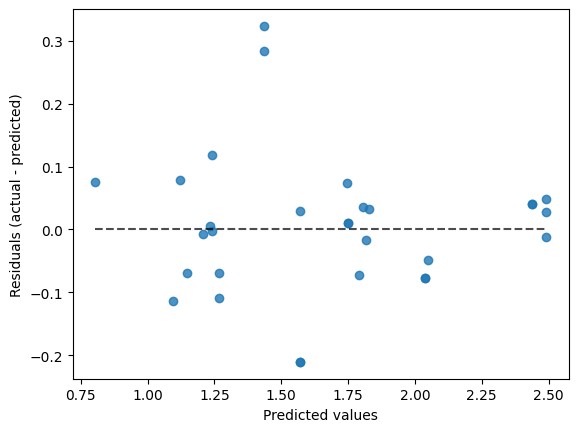

In [38]:
# Отображаем разброс отклонений для предсказанных значений
display = PredictionErrorDisplay(y_true=y_test, y_pred=y_predict)
display.plot()
plt.show()

### Кроссвалидация

In [39]:

# Импортируем линейную регрессию и указываем кол-во фолдов 10
model=LinearRegression()
kfold_validation=KFold(10)

# Получаем метрики точности при помощи кросс валидации
MSE=cross_val_score(model,X_Standardized,y,cv=kfold_validation, scoring='neg_mean_squared_error')
MAE=cross_val_score(model,X_Standardized,y,cv=kfold_validation, scoring='neg_mean_absolute_error')

print(-np.mean(MSE))
print(-np.mean(MAE))
# Делим абсолютное отклонение на средние значения, чтобы узнать % относительного отклонения
print(-np.mean(MAE)/(y.mean()))


0.015833141082027956
0.09445410587239733
Depth    0.079004
Width    0.047936
dtype: float64


Видим из метрик MAE 0.094, среднее отклонение по глубине 7.9%, по ширине 4.8%

## Lasso

In [40]:
# Значения для гиперпараметров
params = {'alpha': (np.logspace(-8, 8, 100))}

lasso = Lasso()
lasso_model = GridSearchCV(lasso, params, cv = 10)

lasso_model.fit(X_train, y_train)

print('Лучшие параметры:', lasso_model.best_params_)

lasso_model = lasso_model.best_estimator_

lasso_model.fit(X_train, y_train)


Лучшие параметры: {'alpha': np.float64(0.001023531021899027)}


Lasso(alpha=np.float64(0.001023531021899027))

In [41]:
dump(lasso_model, './models/lasso.joblib')

['./models/lasso.joblib']

In [42]:
lasso_model = load('./models/lasso.joblib')

### Кроссвалидация

In [43]:
# Получаем метрики точности при помощи кросс валидации
kfold_validation=KFold(10)

MSE=cross_val_score(lasso_model,X_Standardized,y,cv=kfold_validation, scoring='neg_mean_squared_error')
MAE=cross_val_score(lasso_model,X_Standardized,y,cv=kfold_validation, scoring='neg_mean_absolute_error')

print(-np.mean(MSE))
print(-np.mean(MAE))
# Делим абсолютное отклонение на средние значения, чтобы узнать % относительного отклонения
print(-np.mean(MAE)/(y.mean()))

0.016598338073597937
0.09592361258225533
Depth    0.080234
Width    0.048682
dtype: float64


Видим из метрик MAE 0.095, среднее отклонение по глубине 8%, по ширине 4.8%. Значения практически не изменились относительно предыдущей модели. Стали немного хуже.

## Ridge

In [44]:
# Значения для гиперпараметров
params = {'alpha': (np.logspace(-8, 8, 100))}

ridge = Ridge()
ridge_model = GridSearchCV(ridge, params, cv = 10)

ridge_model.fit(X_train, y_train)

print('Лучшие параметры:', ridge_model.best_params_)

ridge_model = ridge_model.best_estimator_

ridge_model.fit(X_train, y_train)


Лучшие параметры: {'alpha': np.float64(0.18738174228603868)}


Ridge(alpha=np.float64(0.18738174228603868))

In [45]:
dump(ridge_model, './models/ridge.joblib')

['./models/ridge.joblib']

In [46]:
ridge_model = load('./models/ridge.joblib')

### Кроссвалидация

In [47]:
# Получаем метрики точности при помощи кросс валидации
kfold_validation=KFold(10)

MSE=cross_val_score(ridge_model,X_Standardized,y,cv=kfold_validation, scoring='neg_mean_squared_error')
MAE=cross_val_score(ridge_model,X_Standardized,y,cv=kfold_validation, scoring='neg_mean_absolute_error')

print(-np.mean(MSE))
print(-np.mean(MAE))
# Делим абсолютное отклонение на средние значения, чтобы узнать % относительного отклонения
print(-np.mean(MAE)/(y.mean()))

0.01620187733386193
0.09509981230597667
Depth    0.079544
Width    0.048264
dtype: float64


Видим из метрик MAE 0.095
Среднее отклонение по глубине 7.9%, по ширине 4.8%, значения не изменились. Значения чуть лучше предыдущей модели.

## Регрессия случайного леса

In [48]:
parameters = {
    'n_estimators': [100, 150, 200, 250, 300, 350],
    'max_depth': [1,2,3,4,5],
}
r_forest = RandomForestRegressor(random_state=0)

r_forest_model = GridSearchCV(r_forest, parameters)

r_forest_model.fit(X_train, y_train)

print('Лучшие параметры:', r_forest_model.best_params_)

r_forest_model = r_forest_model.best_estimator_

r_forest_model.fit(X_train, y_train)

Лучшие параметры: {'max_depth': 5, 'n_estimators': 350}


RandomForestRegressor(max_depth=5, n_estimators=350, random_state=0)

In [49]:
dump(r_forest_model, './models/r_forest.joblib')

['./models/r_forest.joblib']

In [50]:
r_forest_model = load('./models/r_forest.joblib')

### Кроссвалидация

In [51]:
# Получаем метрики точности при помощи кросс валидации
kfold_validation=KFold(10)

MSE=cross_val_score(r_forest_model,X_Standardized,y,cv=kfold_validation, scoring='neg_mean_squared_error')
MAE=cross_val_score(r_forest_model,X_Standardized,y,cv=kfold_validation, scoring='neg_mean_absolute_error')

print(-np.mean(MSE))
print(-np.mean(MAE))
# Делим абсолютное отклонение на средние значения, чтобы узнать % относительного отклонения
print(-np.mean(MAE)/(y.mean()))

0.017879218444766726
0.0886123156355704
Depth    0.074118
Width    0.044971
dtype: float64


Видим из метрик MAE 0.088, среднее отклонение по глубине 7.4%, по ширине 4.4%. Лучшие значения на данный момент

## ElasticNet

In [52]:
# Значения для гиперпараметров
param = {
                'alpha'     : [0.1,1,10,0.01],
                'l1_ratio'  :  np.arange(0.40,1.00,0.10),
                'tol'       : [0.0001,0.001]
            }
eNet = ElasticNet(max_iter=10000)

eNet_model = GridSearchCV(eNet, param)

eNet_model.fit(X_train, y_train)

print('Лучшие параметры:', eNet_model.best_params_)

eNet_model = eNet_model.best_estimator_

eNet_model.fit(X_train, y_train)

Лучшие параметры: {'alpha': 0.01, 'l1_ratio': np.float64(0.4), 'tol': 0.0001}


ElasticNet(alpha=0.01, l1_ratio=np.float64(0.4), max_iter=10000)

In [53]:
dump(eNet_model, './models/eNet.joblib')

['./models/eNet.joblib']

In [55]:
eNet_model = load('./models/eNet.joblib')

### Кроссвалидация

In [56]:
# Получаем метрики точности при помощи кросс валидации
kfold_validation=KFold(10)

MSE=cross_val_score(eNet_model,X_Standardized,y,cv=kfold_validation, scoring='neg_mean_squared_error')
MAE=cross_val_score(eNet_model,X_Standardized,y,cv=kfold_validation, scoring='neg_mean_absolute_error')

print(-np.mean(MSE))
print(-np.mean(MAE))
# Делим абсолютное отклонение на средние значения, чтобы узнать % относительного отклонения
print(-np.mean(MAE)/(y.mean()))

0.019164303494599827
0.09930416150744793
Depth    0.083061
Width    0.050398
dtype: float64


Видим из метрик MAE 0.099, среднее отклонение по глубине 8.3%, по ширине 5%. Значения хуже предыдущей модели

## KNeighborsRegressor

In [57]:
# Значения для гиперпараметров
param = {
                'n_neighbors'     : 	list(range(1, 21)),
                'p'               : [1, 2],
                'weights'         : ["uniform", "distance"]

            }
knn_reg = KNeighborsRegressor()

knn_reg_model = GridSearchCV(knn_reg, param)

knn_reg_model.fit(X_train, y_train)

print('Лучшие параметры:', knn_reg_model.best_params_)

knn_reg_model = knn_reg_model.best_estimator_

Лучшие параметры: {'n_neighbors': 2, 'p': 2, 'weights': 'uniform'}


In [58]:
dump(knn_reg_model, './models/knn.joblib')

['./models/knn.joblib']

In [59]:
knn_reg_model = load('./models/knn.joblib')

### Кроссвалидация

In [60]:
# Получаем метрики точности при помощи кросс валидации
kfold_validation=KFold(10)

MSE=cross_val_score(knn_reg_model,X_Standardized,y,cv=kfold_validation, scoring='neg_mean_squared_error')
MAE=cross_val_score(knn_reg_model,X_Standardized,y,cv=kfold_validation, scoring='neg_mean_absolute_error')

print(-np.mean(MSE))
print(-np.mean(MAE))
# Делим абсолютное отклонение на средние значения, чтобы узнать % относительного отклонения
print(-np.mean(MAE)/(y.mean()))

0.012900892857142854
0.08507142857142856
Depth    0.071156
Width    0.043174
dtype: float64


Видим из метрик MAE 0.089, среднее отклонение по глубине 7.4%, по ширине 4.5%. Хорошие значения но чуть хуже случайного леса

## Нейросеть

In [61]:
param = {'hidden_layer_sizes': [(50, 50, 50), (50, 100, 50), (100), (20)],
          'activation': ['relu', 'tanh', 'logistic'],
          'alpha': [0.0001, 0.05],
          'learning_rate': ['constant', 'adaptive'],
          'solver': ['adam']}

mlp_reg = MLPRegressor()

mlp_reg_model = GridSearchCV(mlp_reg, param)

mlp_reg_model.fit(X_train, y_train)

print('Лучшие параметры:', mlp_reg_model.best_params_)

mlp_reg_model = mlp_reg_model.best_estimator_

Лучшие параметры: {'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'adaptive', 'solver': 'adam'}


In [62]:
dump(mlp_reg_model, './models/mlp.joblib')

['./models/mlp.joblib']

In [63]:
mlp_reg_model = load('./models/mlp.joblib')

### Кроссвалидация

In [64]:
# Получаем метрики точности при помощи кросс валидации
kfold_validation=KFold(10)

MSE=cross_val_score(mlp_reg_model,X_Standardized,y,cv=kfold_validation, scoring='neg_mean_squared_error')
MAE=cross_val_score(mlp_reg_model,X_Standardized,y,cv=kfold_validation, scoring='neg_mean_absolute_error')

print(-np.mean(MSE))
print(-np.mean(MAE))
# Делим абсолютное отклонение на средние значения, чтобы узнать % относительного отклонения
print(-np.mean(MAE)/(y.mean()))

0.018349107706903414
0.10626405492606605
Depth    0.088883
Width    0.053930
dtype: float64


Видим из метрик MAE 0.11, среднее отклонение по глубине 9.4%, по ширине 5.7%. Значения хуже предыдущей модели

# Вывод

Был выполнен разведочный анализ, данные были предобработаны и подготовлены к обучению моделей машинного обучения.

Было обучено несколько различных моделей машинного обучения с разными значениями гиперпараметров, наиболее точной оказалась модель регрессии случайного леса